### 1. Bad $u, v$ for Berlekamp-Massey

[98.9000000000000, 0.000000000000000, 100.000000000000]


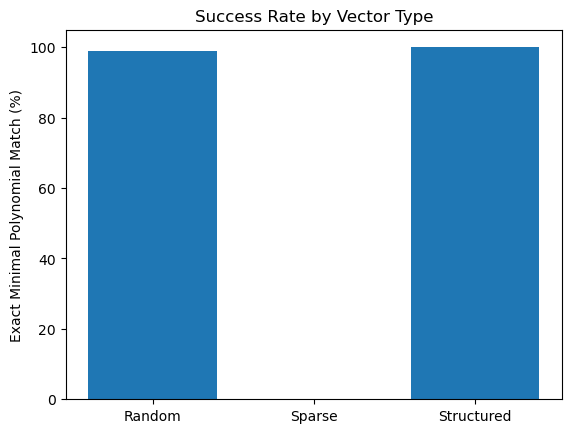

In [4]:
from sage.all import *
from sage.matrix.berlekamp_massey import berlekamp_massey
import random
import matplotlib.pyplot as plt
from collections import defaultdict

f = GF(1009)
# A = matrix(f, [[2, 1, 0, 0], 
#                [0, 2, 0, 0], 
#                [0, 0, 3, 0], 
#                [0, 0, 0, 4]])
A = diagonal_matrix(f, [i // 5 for i in range(5, 36)])
n = A.nrows()

def random_vector():
    return vector(f, [f.random_element() for _ in range(n)])

def sparse_vector(k):
    indices = random.sample(range(n), k)
    v = [f(0)] * n
    for i in indices:
        v[i] = f.random_element()
    return vector(f, v)

def structured_vector():
    return vector(f, [1]*n)

def generate_vectors(category):
    if category == "Random":
        return random_vector(), random_vector()
    elif category == "Sparse":
        return sparse_vector(10), sparse_vector(10)
    elif category == "Structured":
        return structured_vector(), structured_vector()
    else:
        raise ValueError("Unknown category")

def test(A, trials=1000):
    # maybe split into different data types, take it as a parameters?
    categories = ["Random", "Sparse", "Structured"]
    data = []
    min_poly = A.minpoly()
    for cat in categories:
        for _ in range(trials):
            u, v = generate_vectors(cat)
            kappa = [u.dot_product((A^i)*v) for i in range(2*n)]
            mu = berlekamp_massey(kappa)
            bm_poly = PolynomialRing(f, 'x')(mu)
            data.append({
                'type': cat,
                'degree': bm_poly.degree(),
                'equals': bm_poly == min_poly,
                'divides' : min_poly.quo_rem(bm_poly)[0] == 0
            })
    return data

def plot_fix_trials():
    results = test(A, trials=1000)
    summary = {}
    for r in results:
        t = r['type']
        if t not in summary:
            summary[t] = {'count': 0, 'degree_sum': 0, 'success': 0}
        summary[t]['count'] += 1
        summary[t]['degree_sum'] += r['degree']
        summary[t]['success'] += int(r['equals'])
    
    types = list(summary.keys())
    rates = [100.0 * summary[t]['success'] / summary[t]['count'] for t in types]
    print(rates)
    counts = [summary[t]['count'] for t in types]
    bars = plt.bar(types, rates)
    plt.ylabel("Exact Minimal Polynomial Match (%)")
    plt.title("Success Rate by Vector Type")
    plt.show()
    
plot_fix_trials()

### Conclusion
Matrix: 
- More mult eigenvalues: Random success rate closer to 100, sparse success rate higher (roughly 20) -> maybe plot sparsity vs success rate, or multiplicity vs success rate or dimension vs success rate
- No mult: Random success roughly 75, sparse 0
- Structured always 100
- A = diagonal_matrix(f, [i for i in range(1, 31)]) have really low success rate (~15%) -> take LCM
- Success rate independent from eigenvalues (range 1->15 similar to range 15->30), but is dependent on multiplicity / number of distinct eigenvalues
- diag(1,2,...15) has lower success rate than diag(1, 1, 2, 2, ..., 15, 15) -> stronger correlation w mult than no of distinct eigenvalues
- test on both random matrix, random sparse matrix, diagonal matrices, block diagonal matrix, jordan matrix over varying field

Vector:
- Random: high prob (75-95)
- Sparse: almost 0
- Structured: 100